In [2]:
! pip show redis

Name: redis
Version: 6.2.0
Summary: Python client for Redis database and key-value store
Home-page: https://github.com/redis/redis-py
Author: 
Author-email: "Redis Inc." <oss@redis.com>
License-Expression: MIT
Location: /home/pig/miniconda3/envs/raptor/lib/python3.12/site-packages
Requires: 
Required-by: 


In [3]:
import redis
from redis.cluster import RedisCluster, ClusterNode

# Define the startup nodes for your cluster.
# Use the *mapped host ports* you defined in your docker-compose.yml.
startup_nodes = [
    ClusterNode(host="localhost", port=10001),
    ClusterNode(host="localhost", port=10002),
    ClusterNode(host="localhost", port=10003),
    # The client only needs a few nodes for discovery, but listing more doesn't hurt.
    # ClusterNode(host="localhost", port=10004),
    # ClusterNode(host="localhost", port=10005),
    # ClusterNode(host="localhost", port=10006),
]

try:
    # Create a RedisCluster client instance
    # decode_responses=True decodes responses from bytes to strings
    rc = RedisCluster(
        startup_nodes=startup_nodes,
        decode_responses=True,
        skip_full_coverage_check=True,
    )
    # skip_full_coverage_check=True is sometimes useful in local dev if cluster isn't perfectly stable immediately

    print("Successfully connected to Redis Cluster from Python!")

    # --- Perform some basic operations ---

    # Set a key-value pair
    key1 = "user:101:name"
    value1 = "Alice Wonderland"
    rc.set(key1, value1)
    print(f"Set '{key1}' to '{value1}'")

    # Get the value
    retrieved_value1 = rc.get(key1)
    print(f"Retrieved '{key1}': {retrieved_value1}")

    # Set another key (will likely go to a different slot/node unless using hash tags)
    key2 = "product:sku:A123"
    value2 = "Wireless Mouse"
    rc.set(key2, value2)
    print(f"Set '{key2}' to '{value2}'")

    retrieved_value2 = rc.get(key2)
    print(f"Retrieved '{key2}': {retrieved_value2}")

    # Demonstrate a hash tag for co-locating keys
    # Keys within the same {tag} will be on the same hash slot/node.
    rc.hset(
        "cart:{session123}", mapping={"item1": 5, "item2": 2, "timestamp": "2025-06-19"}
    )
    print("Set hash for 'cart:{session123}'")
    cart_data = rc.hgetall("cart:{session123}")
    print(f"Cart data: {cart_data}")

    # Verify cluster health from client perspective
    print("\nCluster nodes as seen by client:")
    for node in rc.get_nodes():
        print(
            f"  {node.host}:{node.port} (role: {node.server_type}, name: {node.name})"
        )

except redis.exceptions.RedisClusterException as e:
    print(f"Error connecting to Redis Cluster: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
finally:
    if "rc" in locals() and rc is not None:
        print("Closing RedisCluster connection (if applicable).")
        # In newer redis-py, explicit close might not be strictly necessary for cluster
        # unless managing connections manually, but good practice for pools.

Successfully connected to Redis Cluster from Python!
Set 'user:101:name' to 'Alice Wonderland'
Retrieved 'user:101:name': Alice Wonderland
Set 'product:sku:A123' to 'Wireless Mouse'
Retrieved 'product:sku:A123': Wireless Mouse
Set hash for 'cart:{session123}'
Cart data: {'item1': '5', 'item2': '2', 'timestamp': '2025-06-19'}

Cluster nodes as seen by client:
  172.19.0.3:6379 (role: primary, name: 172.19.0.3:6379)
  172.19.0.5:6379 (role: replica, name: 172.19.0.5:6379)
  172.19.0.2:6379 (role: primary, name: 172.19.0.2:6379)
  172.19.0.7:6379 (role: replica, name: 172.19.0.7:6379)
  172.19.0.6:6379 (role: primary, name: 172.19.0.6:6379)
  172.19.0.4:6379 (role: replica, name: 172.19.0.4:6379)
Closing RedisCluster connection (if applicable).


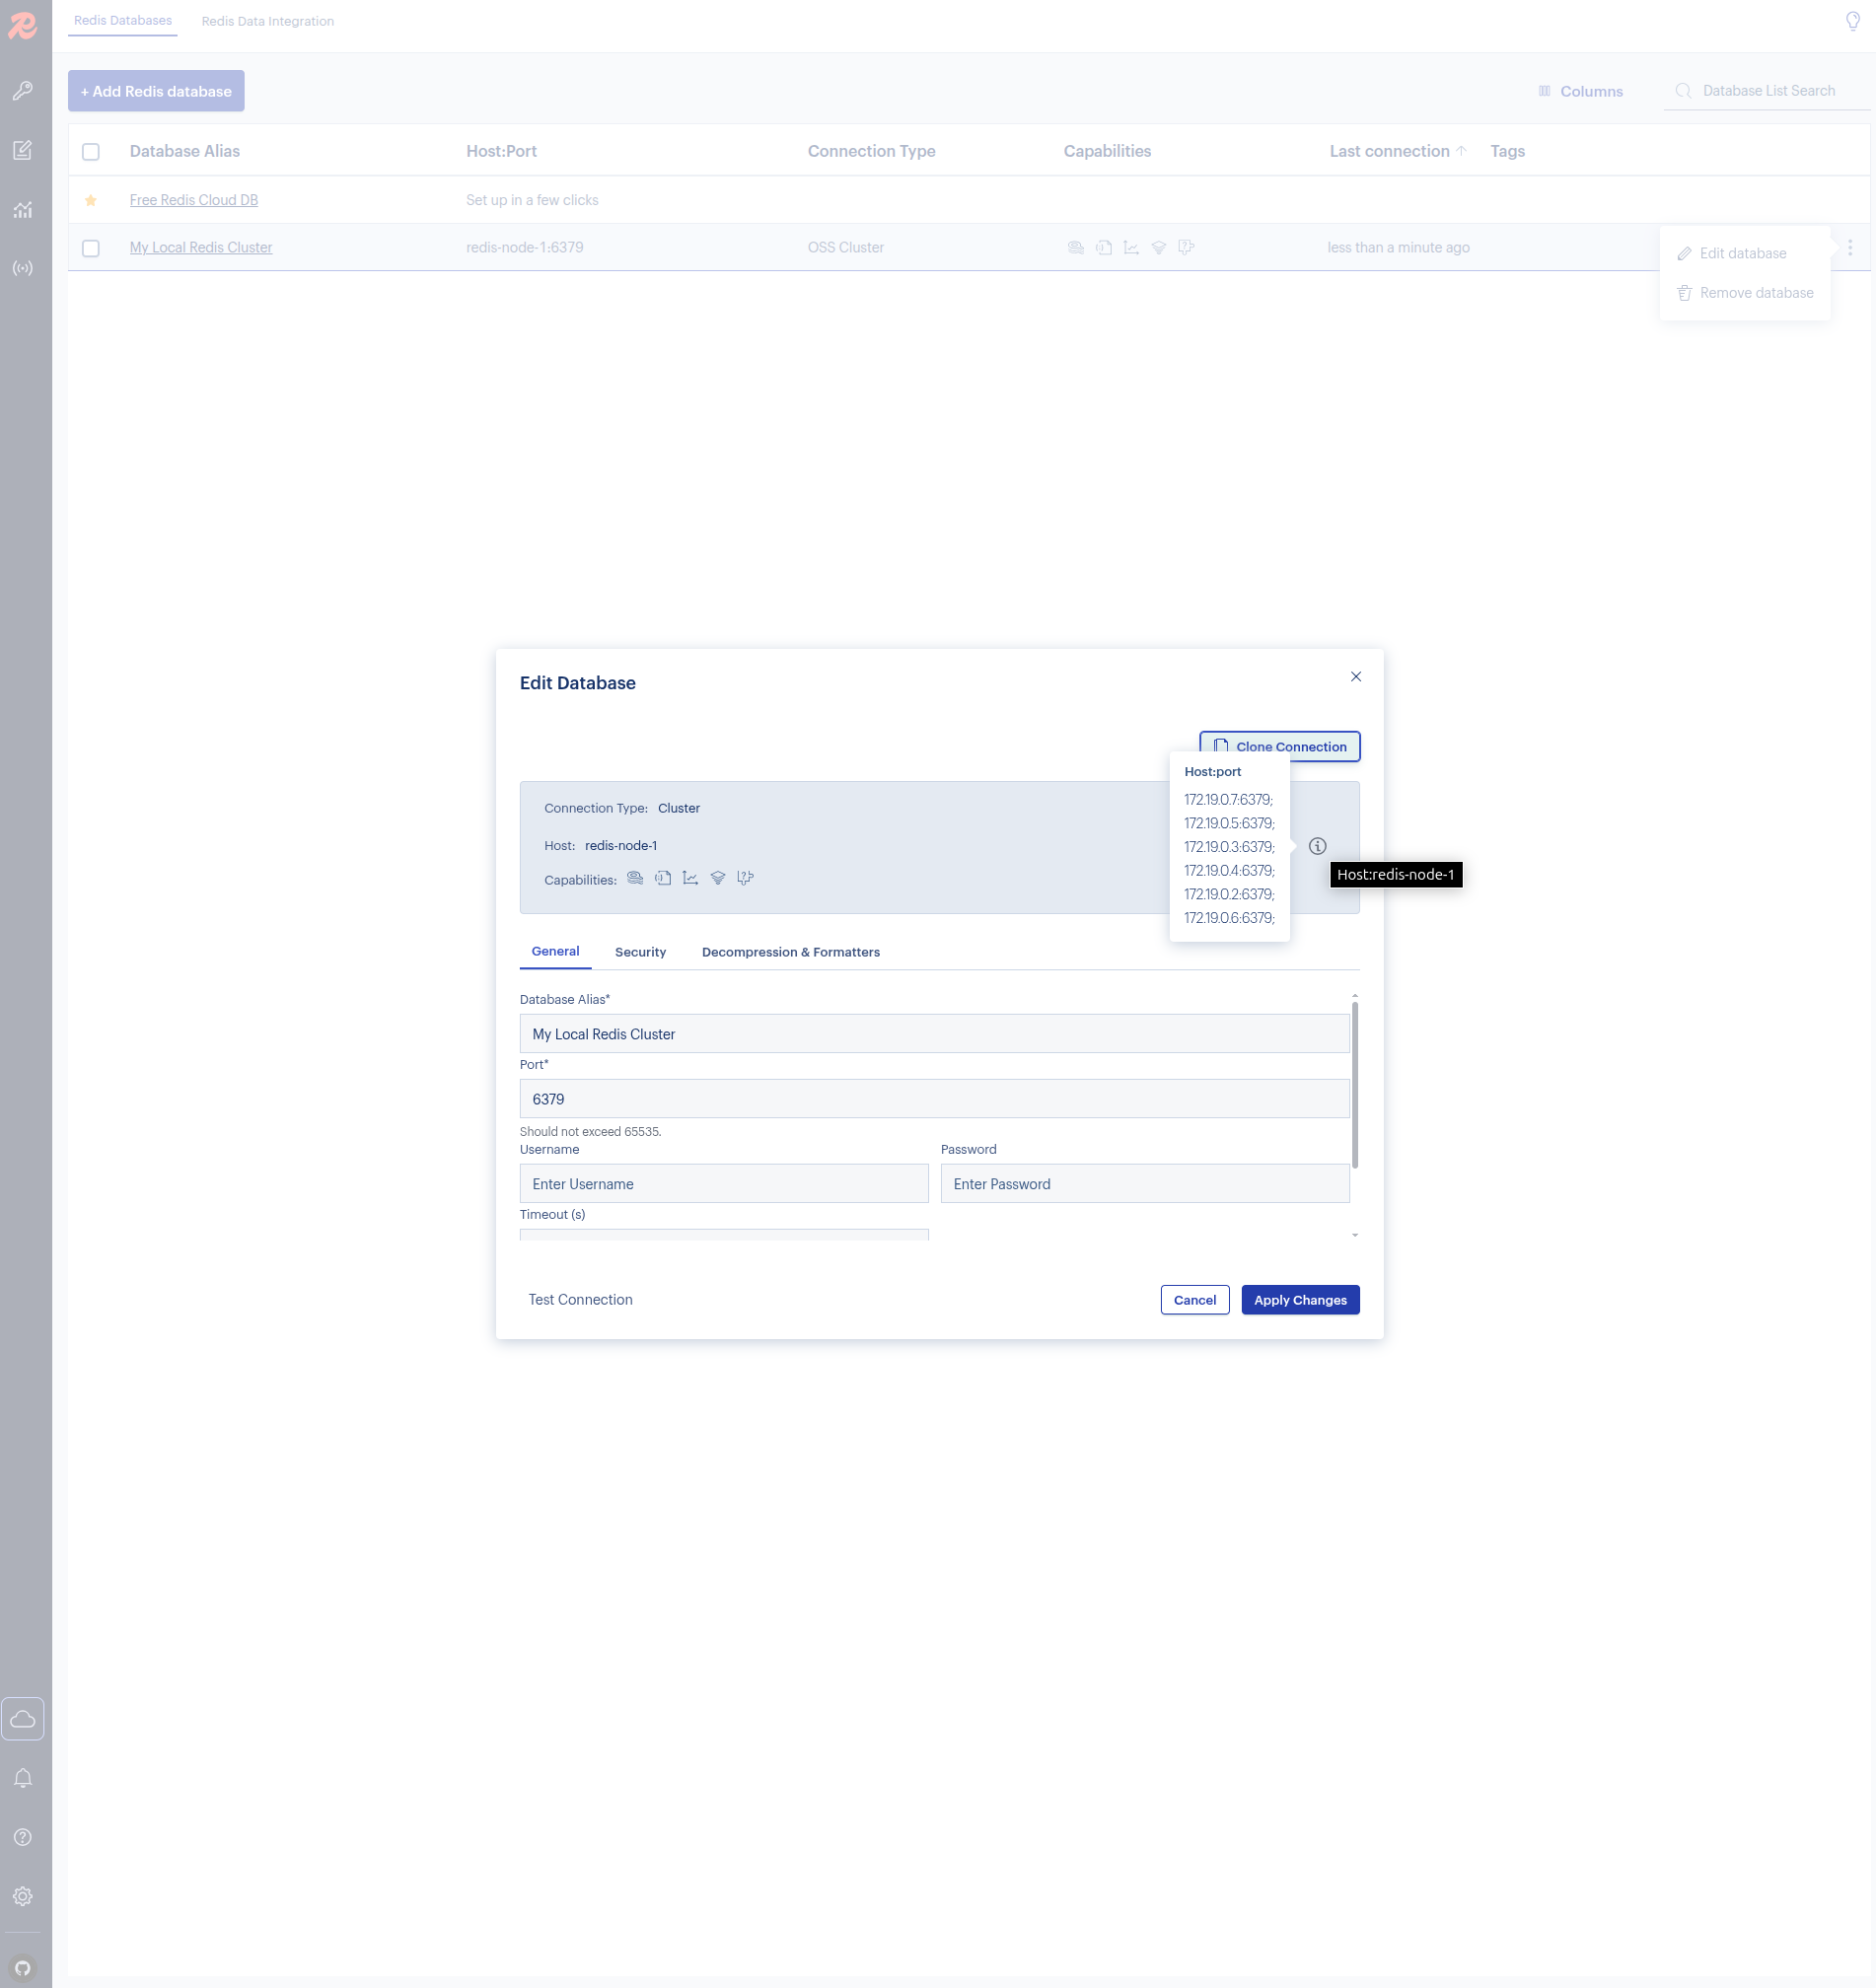